# Fig 4: Analysis of GP output and structure of growth variation

This notebook is used to analyze the Gaussian process output from the file `gp_pipeline.jl`
including the MSD analysis

# Setup and load data

In [10]:
using CSV
using DataFrames
using Distributions
using StatsBase
using PythonPlot
using Random
using Tables
using DifferentialEquations
include("./../src/GrowthTraceTools.jl")
using .GrowthTraceTools
cd(dirname(@__FILE__))

## Load experimental data

In [11]:
# raw data
data_raw = CSV.read("./../output/data_processed.csv",DataFrames.DataFrame);

data_gp = CSV.read("./../output/gp/data/preds.csv",DataFrame)
lineages = unique(data_gp.lineage);
lengths = vcat([
    length(
        unique(data_gp[data_gp.lineage .== lineages[i],:position])
        ) .*
    ones(
        length(
            data_gp[data_gp.lineage .== lineages[i],:time]
            )
        ) 
    for i in eachindex(lineages)]...)
data_gp[:,:length] = lengths
data_gp = data_gp[data_gp.length .>=9,:]
lineages = unique(data_gp.lineage);
unique(data_gp.length)
names(data_gp)

13-element Vector{String}:
 "matern32_cell"
 "matern32_cell_var"
 "matern32_cell_x"
 "matern32_cell_x_var"
 "matern32_flucs"
 "matern32_flucs_var"
 "matern32_flucs_x"
 "matern32_flucs_x_var"
 "time"
 "position"
 "linear"
 "lineage"
 "length"

## High-level visualization of output

### consistency with raw data and example decomposition

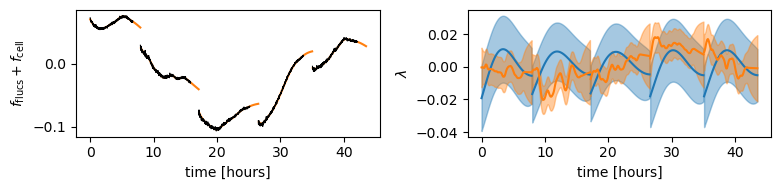

In [12]:
fig,axs = subplots(figsize=(8,2),ncols=2)
k = 3

# -----------------------------------------------------------------------------
# consistency with raw data
ax = axs[0]
dr = data_raw[data_raw.lineage .== lineages[k],:]
dr = dr[dr.cellcycle .== "i",:]
dr.time = dr.time .- dr.time[1]
y = dr.lnM_sum 
t = dr.time
dr[:,:z] = y .- cov(y,t)/var(t) .*t
dr[:,:z] = dr.z .- mean(dr.z)

pred = data_gp[data_gp.lineage .== lineages[k],:]
pred.time = pred.time .- pred.time[1]
#ax.plot(preds[k].time,preds[k].matern32_flucs_x)
for p in unique(pred.position)[1:5]
    d = pred[pred.position .==p,:]
    #ax.plot(d.time,d.matern32_cell_x,"C0-")
    ax.plot(d.time,d.matern32_flucs .+ d.matern32_cell,"C1-",label="GP")
    d = dr[dr.position .==p,:]
    ax.plot(d.time,d.z,"k-",lw=0.8,label="data")

end
ax.set_ylabel(L"$f_{\rm flucs} + f_{\rm cell}$")
ax.set_xlabel("time [hours]")

# -----------------------------------------------------------------------------
# relative size of terms
ax = axs[1]
GrowthTraceTools.get_gen_times!(pred);
#ax.plot(preds[k].time,preds[k].matern32_flucs_x)
for p in unique(pred.position)[1:5]
    d = pred[pred.position .== p,:]

    m,s = d.matern32_cell_x ./ d.gen_time[1],2.0*sqrt.( abs.( d.matern32_cell_x_var))./ d.gen_time[1]
    ax.plot(d.time, m  ,"C0-")
    ax.fill_between(d.time,m .- s,m .+ s,alpha=0.4,color="C0")

    m,s = d.matern32_flucs_x, 2.0* sqrt.(d.matern32_flucs_x_var)
    ax.plot(d.time,m,"C1-")
    ax.fill_between(d.time,m .- s,m .+ s,alpha=0.4,color="C1")
end
ax.set_ylabel(L"$\lambda$")
ax.set_xlabel("time [hours]")
tight_layout()
fig



### Relative contributions to cell-cycle averaged dynamics ($\bar{\lambda}$)

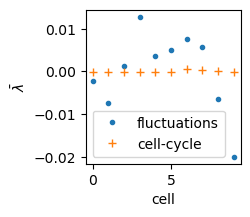

In [4]:
fig,ax = subplots(figsize=(2,2))
#ax.plot(preds[k].time,preds[k].matern32_flucs_x)
positions = unique(pred.position)
d = pred
λbar_flucs = [mean(d[d.position .== p,:].matern32_flucs_x) for p in positions]
λbar_cell = [mean(d[d.position .== p,:].matern32_cell_x  ./ d[d.position .== p,:gen_time][1]) for p in positions]
ax.plot(λbar_flucs .- mean(λbar_flucs) ,"C0.",label="fluctuations")
ax.plot(λbar_cell .- mean(λbar_cell) ,"C1+",label="cell-cycle")
ax.set_ylabel(L"$\bar{\lambda}$")
ax.set_xlabel("cell")
ax.legend(frameon=true)
fig


## Lineage-to-lineage comparisons

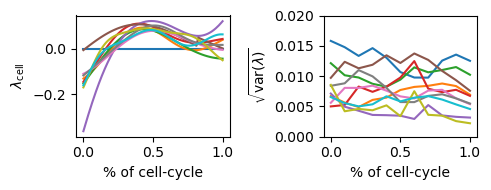

In [5]:


fig, axs= subplots(figsize=(5,2),ncols=2)

# ------------------------------------------------------
# trend
ax = axs[0]
for lin in lineages
    pred = data_gp[data_gp.lineage .== lin,:]
    pred = pred[pred.position .==1,:]
    an = pred.time .- pred.time[1]
    an = an ./ an[end]
    ax.plot(an,pred.matern32_cell_x)
end
ax.set_xlabel("% of cell-cycle")
ax.set_ylabel(L"$\lambda_{\rm cell}$")

# ------------------------------------------------------
# variance vs. cell-cycle
ax = axs[1]
for lin in lineages
    pred = data_gp[data_gp.lineage .== lin,:]
    if length(unique(pred.position))>6
        pred = combine(groupby(pred,:position),:time => (x -> x .- x[1]) => :age,:time => (x -> (x .- x[1]) ./ (x[end] - x[1])) => :age_normed,names(pred))
        pred[:,:age_normed] = round.(pred.age_normed,digits=1)
        vdf = combine(groupby(pred,:age_normed),:matern32_flucs_x => std => :v)
        sort!(vdf,:age_normed)
        ax.plot(vdf.age_normed,vdf.v,"-")
    end
end
ax.set_ylim([0,0.02])
ax.set_xlabel("% of cell-cycle")
ax.set_ylabel(L"$\sqrt{{\rm var}(\lambda)}$")
tight_layout()
fig

fig

# Prediction of variance of cell-cycle averaged growth

## Setup

we load simulated data which has been fit to instantaneous growth rates

In [6]:
data_cells = combine(groupby(data_gp,[:lineage,:position]),
    :matern32_flucs_x=>mean=>:gr,
    :time=>(x->x[end]-x[1])=>:gt,:length=> mean => :length);
lineages = unique(data_cells.lineage)
# get time interval for predicted arrays
dt = mean(diff(data_gp[data_gp.lineage .== lineages[1],:time])); 

# get sims
sims = CSV.read("./../output/sims_OUfit.csv",DataFrame);
sims_cells = combine(groupby(sims,[:lineage_original,:replicate,:position]),
    :λ=>mean=>:gr,
    :time=>(x->x[end]-x[1])=>:gt,:length=> mean => :length);
sims_cells[:,:lineage] = sims_cells.lineage_original



# get sim after gp
sims_gp = CSV.read("./../output/gp/sims_fig4/preds.csv",DataFrame);
sims_cells_gp = combine(groupby(sims_gp,[:lineage,:position]),
    :matern32notrend_flucs_x=>mean=>:gr,
    :time=>(x->x[end]-x[1])=>:gt);

### Check distribution of growth rates in simulated data looks reasonable 

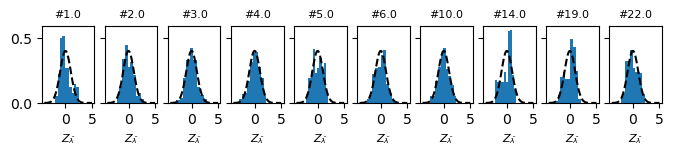

In [7]:
fig, axs = subplots(figsize=(8,1),ncols=length(lineages),sharey=true,sharex=true)
for i in eachindex(lineages)
    ax = axs[i-1]
    d = sims[sims.lineage .==lineages[i],:]
    ax.hist((d.λ .- mean(d.λ)) ./ std(d.λ),10,density=true)
    xrng = collect(-4:0.1:5)
    ax.plot(xrng,1.0 ./sqrt(2 .*π) .* exp.(-xrng .^2/2),"k--")
    ax.set_title("#"*string(lineages[i]),fontsize=8)
    ax.set_xlabel(L"$Z_{\bar{\lambda}}$",fontsize=8)
end
fig

## Visual Comparison of simulations to data

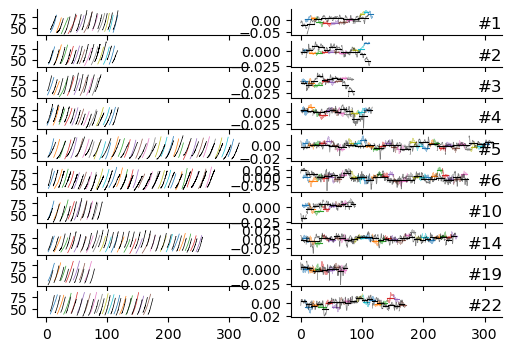

In [8]:
lw=0.5
fig,axs =subplots(figsize=(6,4),nrows=length(lineages),sharex="col",ncols=2)
for i in eachindex(lineages)
    lin = lineages[i]

    # ------------------------------------------
    ax = axs[i-1,0]

    sims1 = sims[sims.lineage_original .==lin,:]
    
    #dd = data_gp[data_gp.lineage .==lin,:]
    dd = data_raw[data_raw.lineage .==lin,:]
    GrowthTraceTools.get_gen_times!(dd);
    #dd.λ = vcat([dd[dd.position .== p,:].matern32_flucs_x .+ dd[dd.position .== p,:].matern32_cell_x ./ dd[dd.position .== p,:gen_time][1]  for p in unique(dd.position)]...)
    #dd.λ = dd.matern32_flucs_x
    for j in 1:1
        ds = sims1[sims1.replicate .==j,:]
        [ax.plot(ds[ds.position .==p,:].time,ds[ds.position .==p,:].M,lw=0.5) for p in unique(ds.position)]
    end
    [ax.plot(dd[dd.position .==p,:].time,dd[dd.position .==p,:].M,"k",lw=0.5) for p in unique(dd.position)]
    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)


    # ------------------------------------------
    ax = axs[i-1,1]

 

    for j in 1:1
        ds = sims1[sims1.replicate .==j,:]
        for p in unique(ds.position)
            t = ds[ds.position .==p,:].time
            λ =  ds[ds.position .==p,:].λ
            λ  = λ .- mean(ds.λ)
            ax.plot(t,λ ,"C"*string(Int64(p))*"-",lw=lw,alpha=0.5)
            ax.plot(t,mean(λ) .*ones(length(t)),"C"*string(Int64(p))*"-",lw=0.8)
        end
    end
    
    dd = data_gp[data_gp.lineage .==lin,:]
    GrowthTraceTools.get_gen_times!(dd);
    dd.λ = dd.matern32_flucs_x
    for p in unique(dd.position)
        t = dd[dd.position .==p,:].time
        ax.plot(t,dd[dd.position .==p,:].λ,"k-",lw=lw,alpha=0.5)
        ax.plot(t,mean(dd[dd.position .==p,:].λ) .*ones(length(t)),"k-",lw=0.8)
    end
    ax.set_title("#"*string(Int64(lin)),y=1.0, pad=-14,loc="right")
    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)

  
end

#axs[length(lineages)-1,0].set_xlabel("time [hours]")
#axs[length(lineages)-1,1].set_xlabel("time [hours]")
savefig("./../figures/OU_vs_data.pdf")
fig

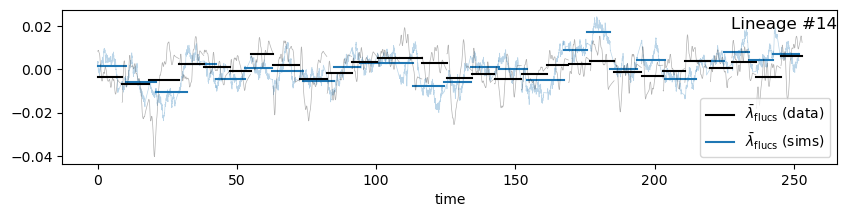

In [9]:
fig,ax =subplots(figsize=(10,2))
lw = 0.5
lin = lineages[8]
sims1 = sims[sims.lineage_original .==lin,:]
sims1.time = sims1.time .- sims1.time[1]
for j in 1:1
    ds = sims1[sims1.replicate .==j,:]
    for p in unique(ds.position)
        t = ds[ds.position .==p,:].time
        λ =  ds[ds.position .==p,:].λ
        λ  = λ .- mean(ds.λ)
        ax.plot(t,λ ,"C0-",lw=lw,alpha=0.3)
        ax.plot(t,mean(λ) .*ones(length(t)),"C0-")
    end
end

dd = data_gp[data_gp.lineage .==lin,:]
GrowthTraceTools.get_gen_times!(dd);
dd.λ = dd.matern32_flucs_x
for p in unique(dd.position)
    t = dd[dd.position .==p,:].time
    ax.plot(t,dd[dd.position .==p,:].λ,"k-",lw=lw,alpha=0.3)
    ax.plot(t,mean(dd[dd.position .==p,:].λ) .*ones(length(t)),"k-")
end
ax.plot([0],[0],"k-",label=L"$\bar{\lambda}_{\rm flucs}$ (data)")
ax.plot([0],[0],"C0-",label=L"$\bar{\lambda}_{\rm flucs}$ (sims)")
ax.set_title("Lineage #"*string(Int64(lin)),y=1.0, pad=-14,loc="right")
ax.set_xlabel("time")
ax.legend(frameon=true)
savefig("./../figures/lineage_example.pdf")
fig


## Look at summary statistics

In [35]:
var_df_sims = combine(groupby(sims_cells,[:lineage,:replicate]),:gr=> var => :gr_var,:gr=> mean => :gr_mean,:length=> (x -> x[1]) => :length)
var_df_data = combine(groupby(data_cells,:lineage),:gr=> var => :gr_var,:gr=> mean => :gr_mean,:length => mean => :length);
var_df_sims_gp = combine(groupby(sims_cells_gp,:lineage),:gr=> var => :gr_var,:gr=> mean => :gr_mean);
# var_df_sims.cv = var_df_sims.gr_var ./ var_df_data.gr_mean .^2
# var_df_data.cv = var_df_data.gr_var ./ var_df_data.gr_mean .^2
var_df_sims_gp.cv = var_df_sims_gp.gr_var ./ var_df_sims_gp.gr_mean .^2


sims_means = combine(groupby(var_df_sims,:lineage),:gr_var => mean => :gr_var_avg).gr_var_avg
sims_std = combine(groupby(var_df_sims,:lineage),:gr_var => std => :gr_var_std).gr_var_std; 

CSV.write("./../output/var_table_data.csv",var_df_data)
CSV.write("./../output/var_table_sims.csv",var_df_sims)

"./../output/var_table_sims.csv"

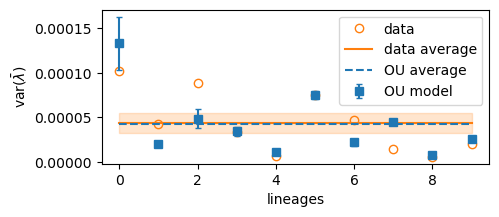

In [36]:
nreps = length(unique(sims.replicate))
fig, ax= subplots(figsize=(5,2))


ax.plot(var_df_data.gr_var,"C1o",label="data",fillstyle="none")
ax.plot(ones(length(sims_means)) .* mean(var_df_data.gr_var),"C1-",label="data average")
#ax.plot(var_sims_gp,"C0+",label="sims (GP)",fillstyle="none",markersize=10)
ax.errorbar(0:(length(sims_means)-1),sims_means,yerr=sims_std ./sqrt(10),label="OU model",capsize=2,marker="s",color="C0",linestyle="none")
ax.plot(ones(length(sims_means)) .* mean(sims_means),"C0--",label="OU average")

ax.fill_between(0:(length(lineages)-1),ones(length(var_df_data.gr_var)) .* mean(var_df_data.gr_var) .-  std(var_df_data.gr_var)/sqrt(length(lineages)), 
ones(length(var_df_data.gr_var)) .* mean(var_df_data.gr_var) .+  std(var_df_data.gr_var)/sqrt(length(lineages)),alpha=0.2,color="C1")
ax.legend(frameon=true)
ax.set_ylabel(L"${\rm var}(\bar{\lambda})$")
ax.set_xlabel("lineages")
#ax.set_ylim([0,0.001])
savefig("./../figures/OU_vs_data.pdf",bbox_inches="tight")
fig


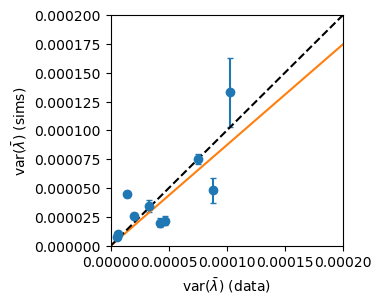

In [37]:
lengths = var_df_data.length
fig, ax= subplots(figsize=(3,3))
ax.errorbar(var_df_data.gr_var,sims_means,yerr = sims_std ./sqrt(10),marker="o",linestyle="none",capsize=2,label="raw sims")
ax.plot([0,0.002],[0,0.002*cov(var_df_data.gr_var,sims_means)/var(var_df_data.gr_var)])
#ax.plot(var_df_data.gr_var,var_sims_gp ,"C0.",label="Gaussian process")
ax.plot([0,0.002],[0,0.002],"k--")
#ax.loglog([mean(var_df_data.gr_var)],[mean(sims_means)],"C0+",label="average",markersize=10)
#ax.loglog([mean(var_df_data.gr_var)],[mean(var_sims_gp)],"C0s",label="average",markersize=10)
ax.set_xlabel(L"${\rm var}(\bar{\lambda})$ (data)")
ax.set_ylabel(L"${\rm var}(\bar{\lambda})$ (sims)")
ax.set_ylim([0,0.0002])
ax.set_xlim([0,0.0002])
savefig("./../figures/varlambdabar-OU_vs_data.pdf",bbox_inches="tight")
fig


### Check that Gaussian process is perserving variance

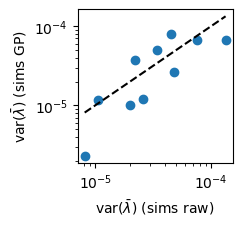

In [38]:

fig, ax= subplots(figsize=(2,2))
ax.plot(sims_means,var_df_sims_gp.gr_var,"o")
ax.loglog(sort(sims_means),sort(sims_means),"k--")
ax.set_ylabel(L"${\rm var}(\bar{\lambda})$ (sims GP)")
ax.set_xlabel(L"${\rm var}(\bar{\lambda})$ (sims raw)")
#ax.set_ylim([0,0.0002])
#ax.set_xlim([0,0.0002])
savefig("./../figures/varlambdabar-GP_vs_sims.pdf",bbox_inches="tight")
fig
